In [240]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# EXTRAINDO DADOS

In [241]:
tables  = [os.path.join('files', file) for file in os.listdir('files') if '.csv' in file]
indexes = sorted([int(tab.replace('.', '_').split('_')[-2]) for tab in tables])
files = [os.path.join('files', f'test_{i}.csv') for i in indexes]

print(indexes)
files

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


['files/test_1.csv',
 'files/test_2.csv',
 'files/test_3.csv',
 'files/test_4.csv',
 'files/test_5.csv',
 'files/test_6.csv',
 'files/test_7.csv',
 'files/test_8.csv',
 'files/test_9.csv',
 'files/test_10.csv',
 'files/test_11.csv',
 'files/test_12.csv',
 'files/test_13.csv',
 'files/test_14.csv',
 'files/test_15.csv',
 'files/test_16.csv',
 'files/test_17.csv',
 'files/test_18.csv',
 'files/test_19.csv',
 'files/test_20.csv',
 'files/test_21.csv',
 'files/test_22.csv',
 'files/test_23.csv']

In [242]:
df   = pd.DataFrame()
time = 0.00

for path in files:
    data = pd.read_csv(path)
    data["time"] = (data.time.values - data.time.values[0]) + time

    df   = pd.concat([df, data], axis=0)
    time = df.time.max()


df = df[['time', 'pressure']]
df

,time,pressure
0,0.0,40.10467
1,0.1,40.10160
2,0.2,40.09878
3,0.3,40.09624
4,0.4,40.09407
...,...,...
1936,2549.8,19.72000
1937,2549.9,19.72000
1938,2550.0,19.72500
1939,2550.1,19.72500


# ESCALONAMENTO MÓVEL

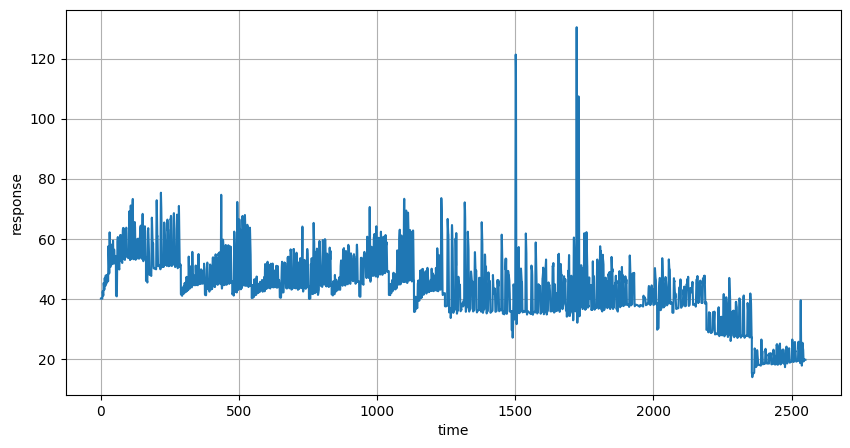

In [243]:
plt.figure(figsize=(10, 5))
plt.plot(df.time, df.pressure)
plt.xlabel('time'); plt.ylabel('response')
plt.grid()

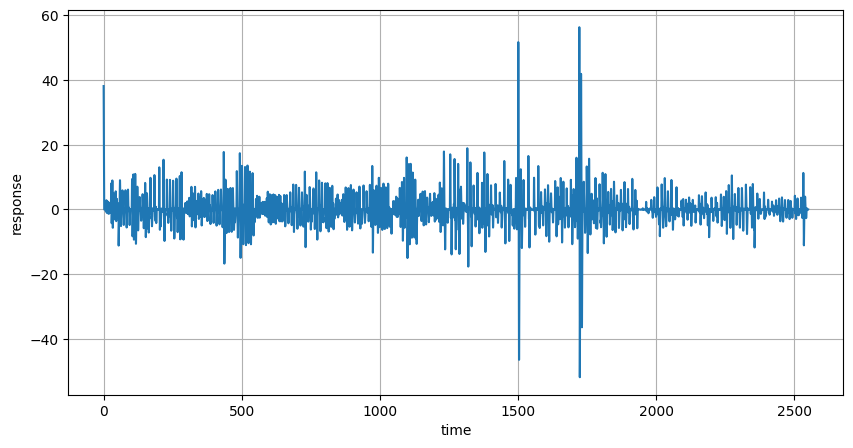

In [244]:
import numpy as np

class Smoother:
    def __init__(self, size):
        self.size = size
        self.reset()

    def reset(self):
        self.array = np.zeros(self.size)
        self.sum   = 0.00
        self.i = 0

    def update(self, value):
        self.sum = self.sum - self.array[self.i]
        self.array[self.i] = value

        self.sum = self.sum + self.array[self.i]
        self.i = (self.i + 1) if (self.i + 1 < self.size) else 0
        return (self.sum / self.size)


N_SMOOTHER = 20
smoother       = Smoother(N_SMOOTHER)
df['pressure'] = [value - smoother.update(value) for value in df.pressure.values]

plt.figure(figsize=(10, 5))
plt.plot(df.time, df.pressure)
plt.xlabel('time'); plt.ylabel('response')
plt.grid()

# ESTADOS ANTERIORES

In [245]:
def getStates(df, key, var='y', n=10):
    table = pd.DataFrame()
    table[f'{var}'] = df[key]
    
    for i in range(1, n):
        table[f'{var}(n-{i})'] = df[key].shift(i)
    
    table.dropna(inplace=True) 
    return table.reset_index(drop=True)


N_STATES = 5
xData = getStates(df, 'pressure', var='y', n=N_STATES)
xData

,y,y(n-1),y(n-2),y(n-3),y(n-4)
0,30.069302,32.076176,34.083527,36.091286,38.099436
1,28.062945,30.069302,32.076176,34.083527,36.091286
2,26.057084,28.062945,30.069302,32.076176,34.083527
3,24.051603,26.057084,28.062945,30.069302,32.076176
4,22.046521,24.051603,26.057084,28.062945,30.069302
...,...,...,...,...,...
25516,0.029250,0.032250,0.030500,0.033500,0.036500
25517,0.026250,0.029250,0.032250,0.030500,0.033500
25518,0.028000,0.026250,0.029250,0.032250,0.030500
25519,0.025000,0.028000,0.026250,0.029250,0.032250


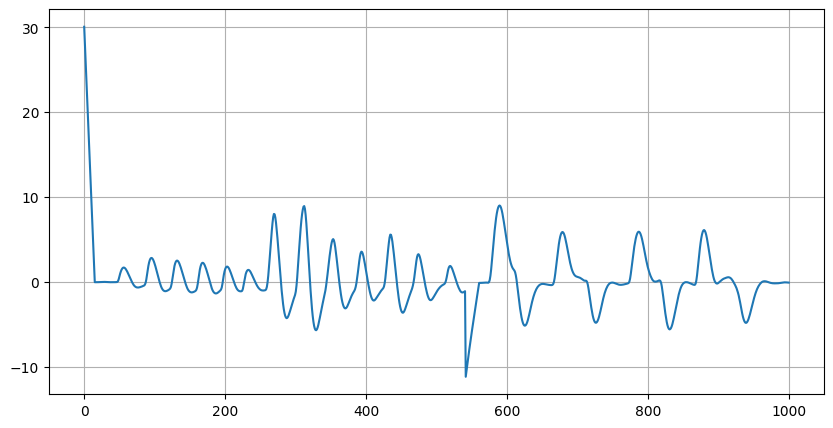

In [246]:
plt.figure(figsize=(10, 5))
plt.plot(xData.y[:1000])
plt.grid()

# CLUSTERING

In [247]:
class Cluster:
    def __init__(self, xData):
        self.xData = xData

    def analyse(self, cluster_range=(2, 10)):
        xData = StandardScaler().fit_transform(self.xData)
        inertias    = []
        silhouettes = []
        cluster_range = range(*cluster_range)

        for k in cluster_range:
            model  = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = model.fit_predict(xData)

            inertias.append(model.inertia_)
            silhouette_avg = silhouette_score(xData, labels)
            silhouettes.append(silhouette_avg)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(cluster_range, inertias, 'bx-')
        plt.xlabel('num clusters'); plt.ylabel('erro quadrático (inércia)')
        plt.title('Método do Cotovelo\n(Procure a "dobra" da linha)')
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(cluster_range, silhouettes, 'bx-')
        plt.xlabel('num clusters'); plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score\n(Quanto maior, melhor)')
        plt.grid()
        plt.show()

    def guess(self, n=None):
        if n is None:
            model = DBSCAN(eps=0.5, min_samples=5)
        else:
            model = KMeans(n_clusters=n, random_state=42, n_init=10)

        xData  = StandardScaler().fit_transform(self.xData)
        labels = model.fit_predict(xData)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(xData)
        plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels)
        plt.title(f'n_clusters: {n_clusters}'); plt.grid();
        return n_clusters


cluster = Cluster(xData)
#cluster.analyse()

3

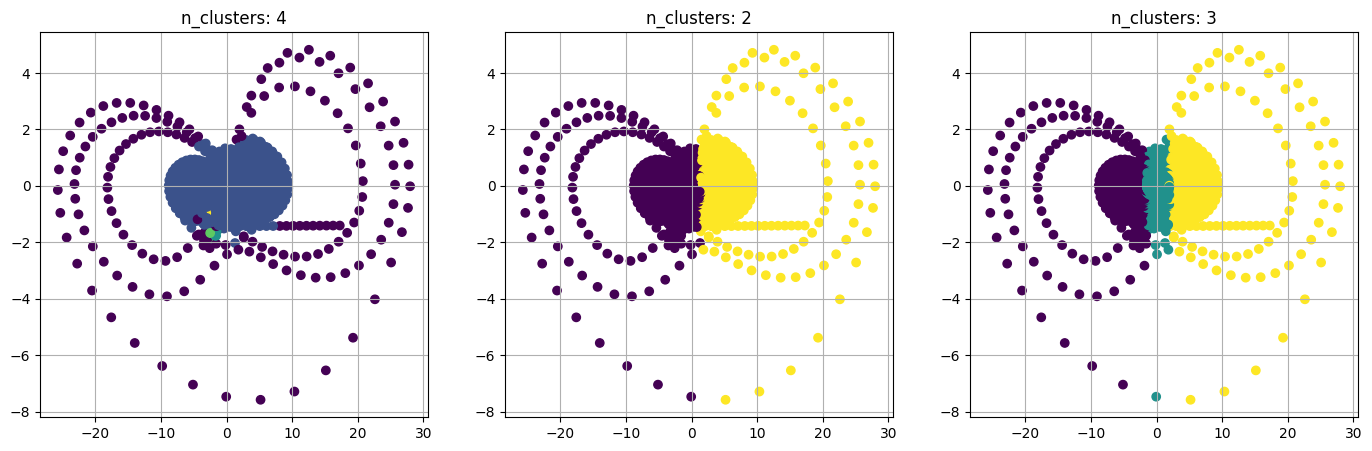

In [248]:
NUM_CLUSTERS = 2

plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
cluster.guess()

plt.subplot(1, 3, 2)
cluster.guess(NUM_CLUSTERS)

plt.subplot(1, 3, 3)    
cluster.guess(NUM_CLUSTERS+1)

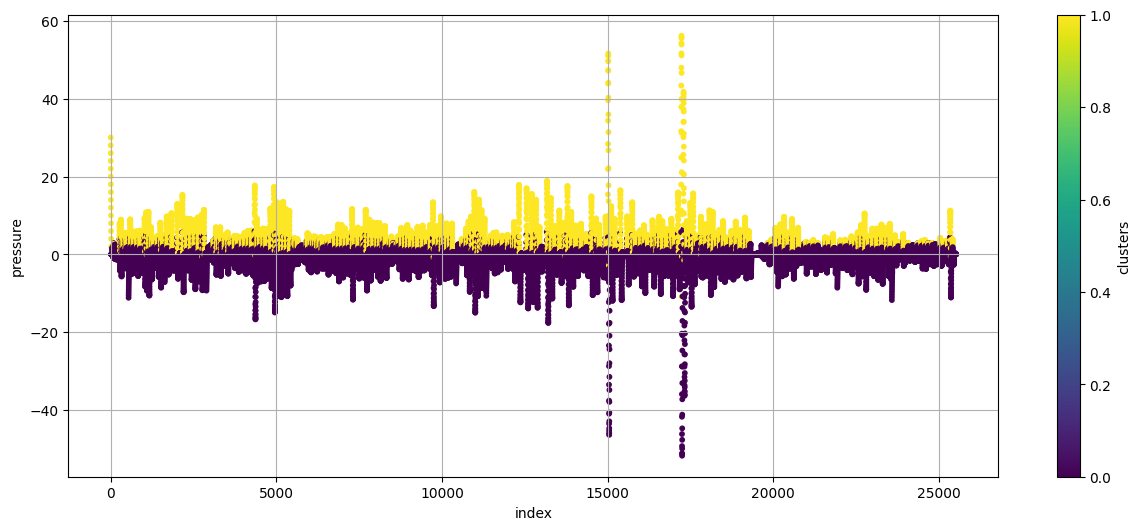

In [249]:
model = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)

scaler = StandardScaler()
X      = scaler.fit_transform(xData)
yModel = model.fit_predict(X)

xData = getStates(df, 'pressure', var='y', n=N_STATES)
xData['cluster'] = yModel

plt.figure(figsize=(15, 6))
scatter = plt.scatter(xData.index, xData.y, c=xData.cluster, cmap='viridis', s=10)
plt.colorbar(scatter, label='clusters')
plt.xlabel('index'); plt.ylabel('pressure')
plt.grid()

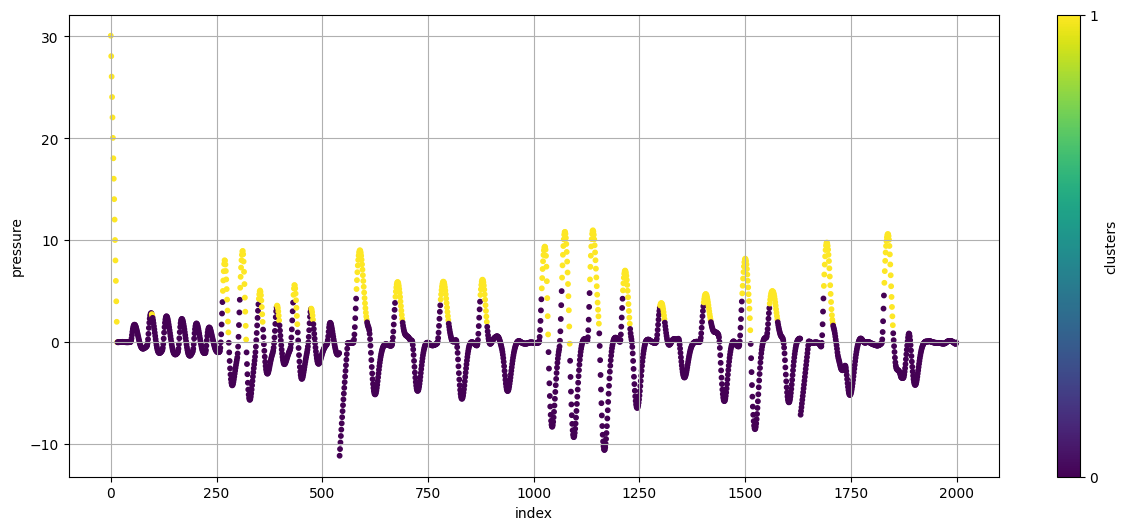

In [250]:
STEP = 2000

for i in range(0, 2, STEP):
    target = xData.iloc[i:i+STEP]

    plt.figure(figsize=(15, 6))
    scatter = plt.scatter(target.index, target.y, c=target.cluster, cmap='viridis', s=10)
    plt.colorbar(scatter, label='clusters', ticks=range(0, NUM_CLUSTERS+1))
    plt.xlabel('index'); plt.ylabel('pressure')
    plt.grid()

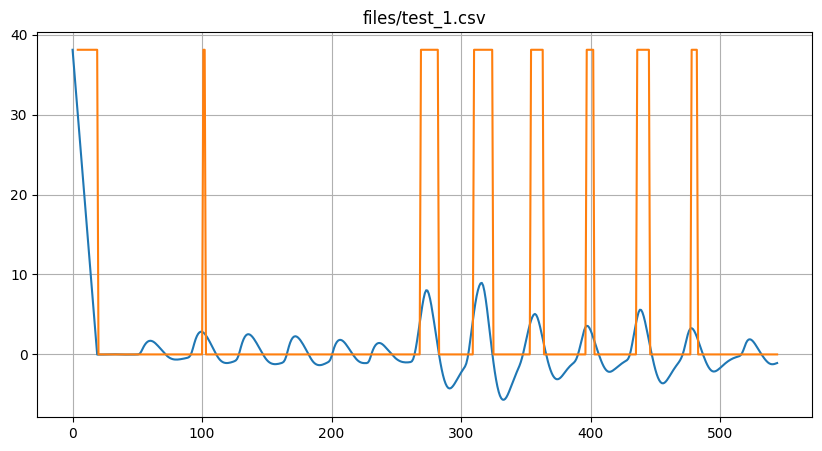

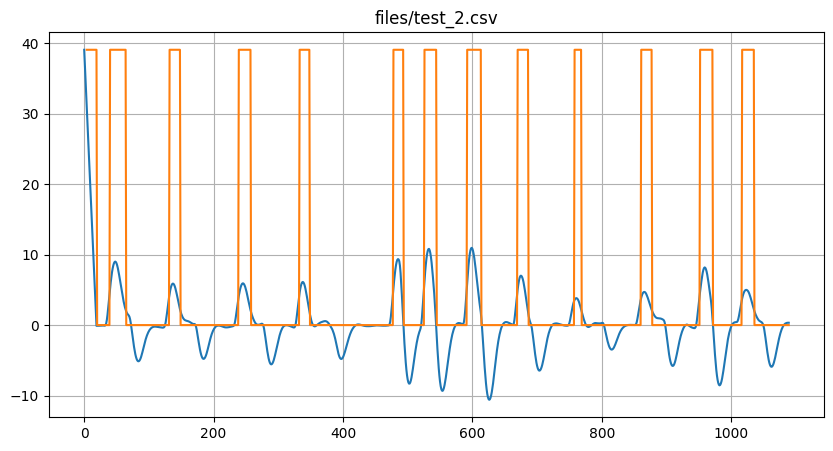

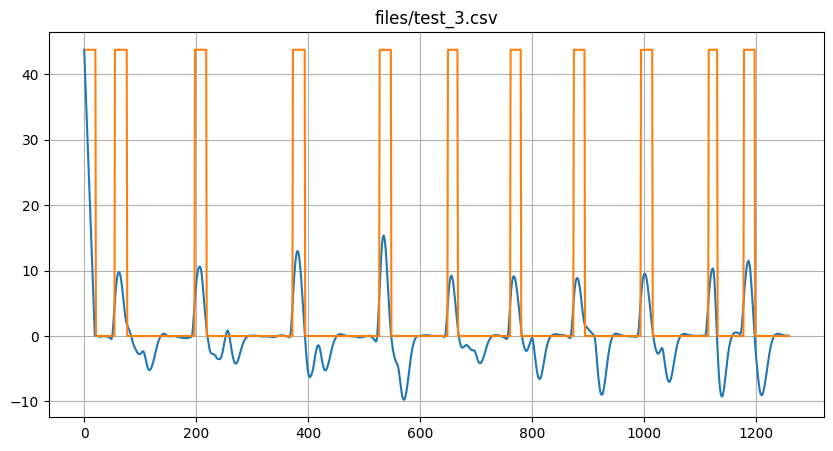

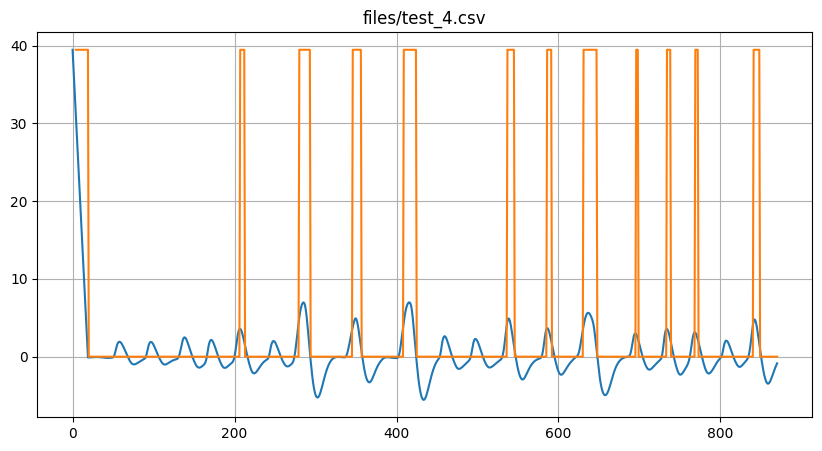

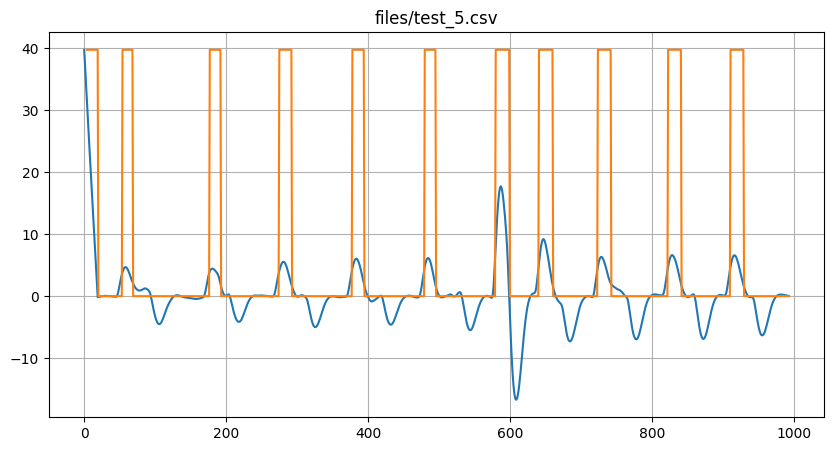

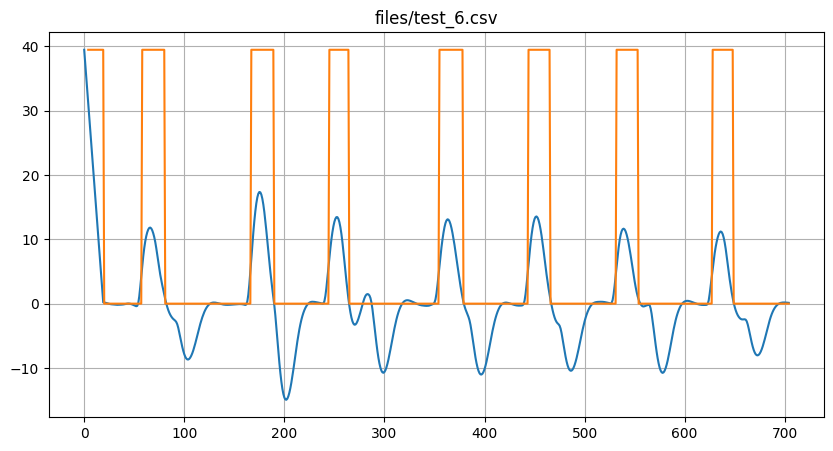

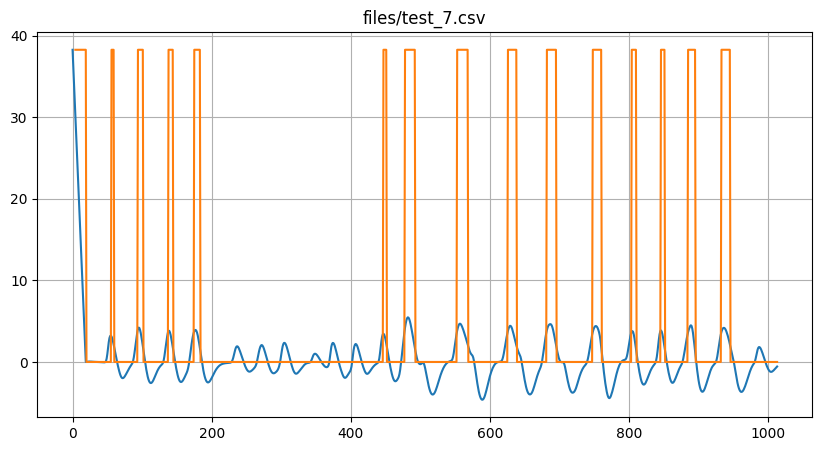

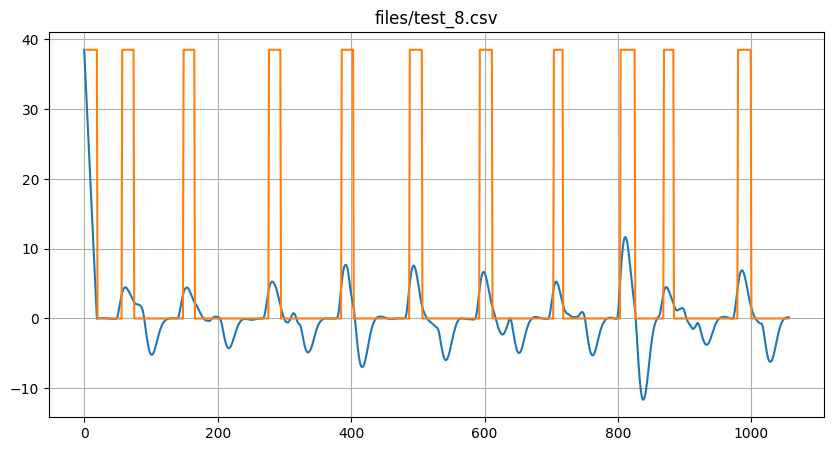

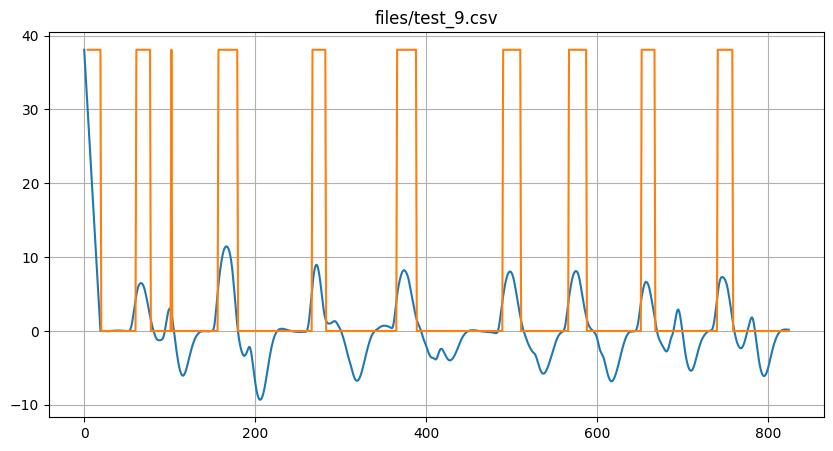

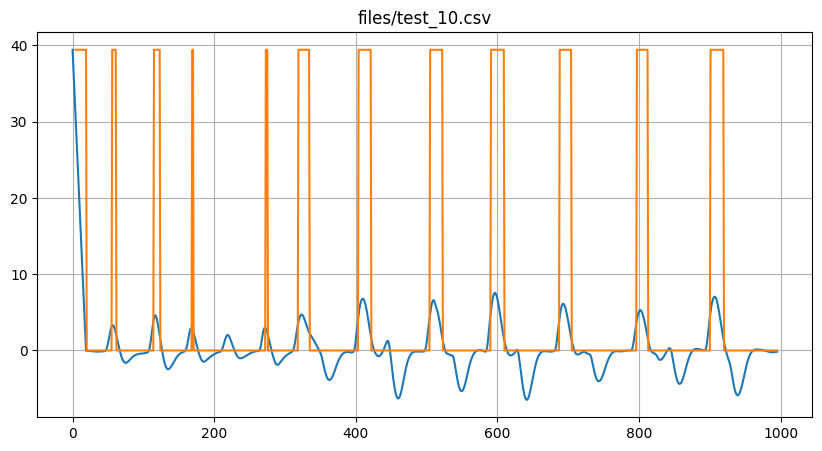

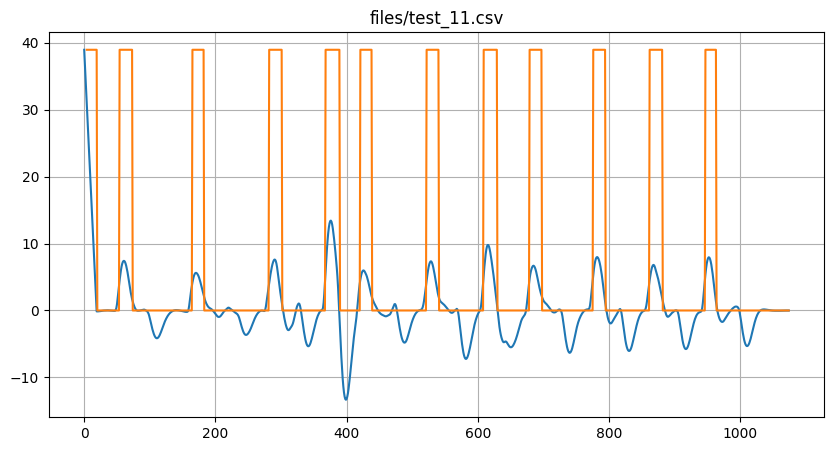

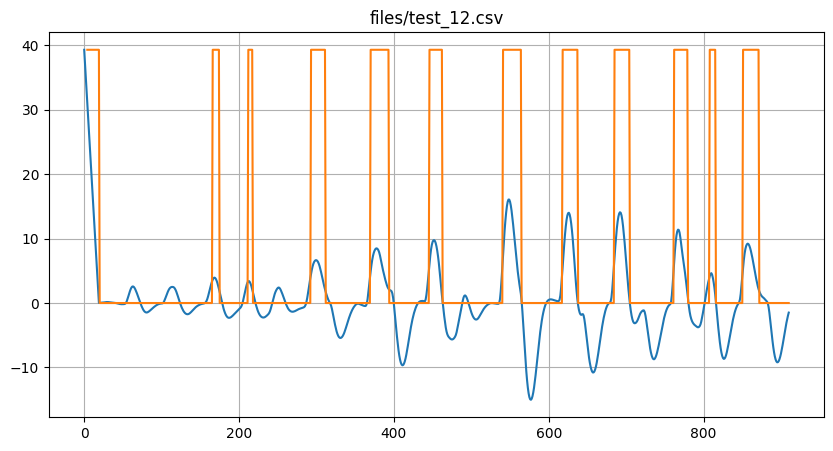

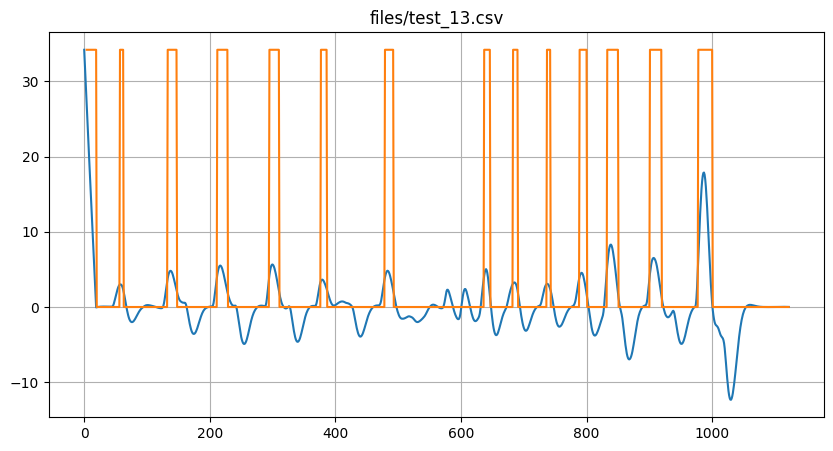

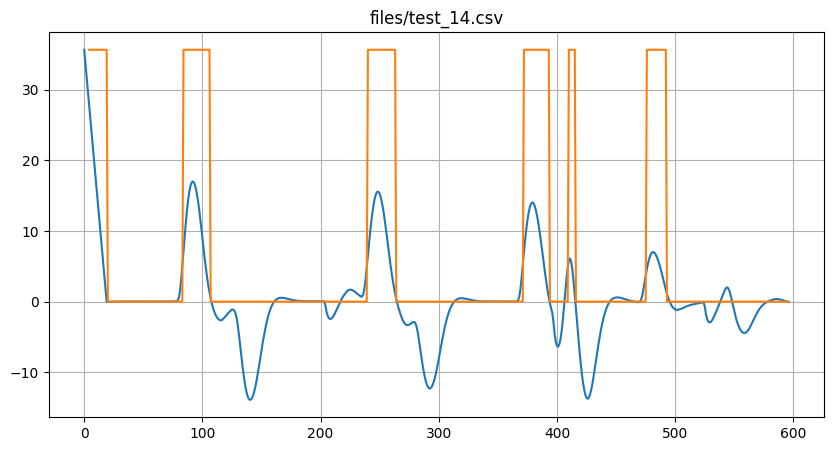

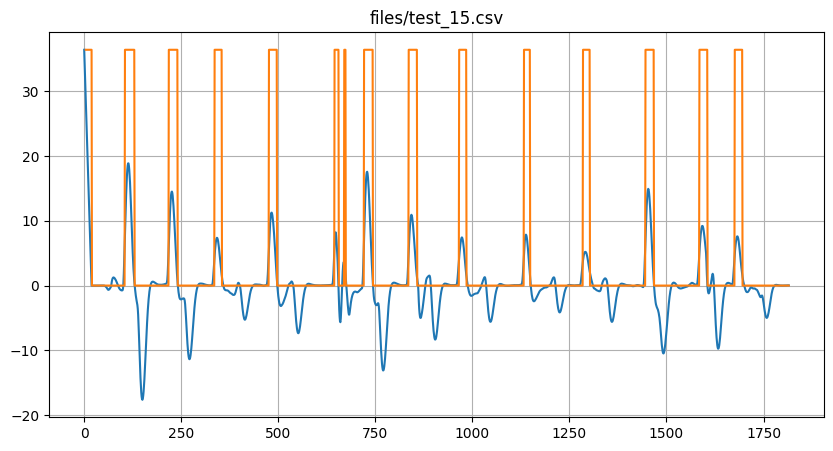

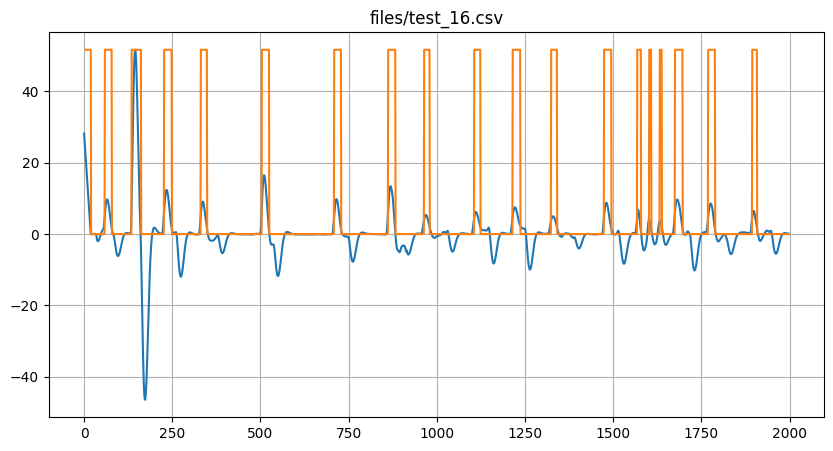

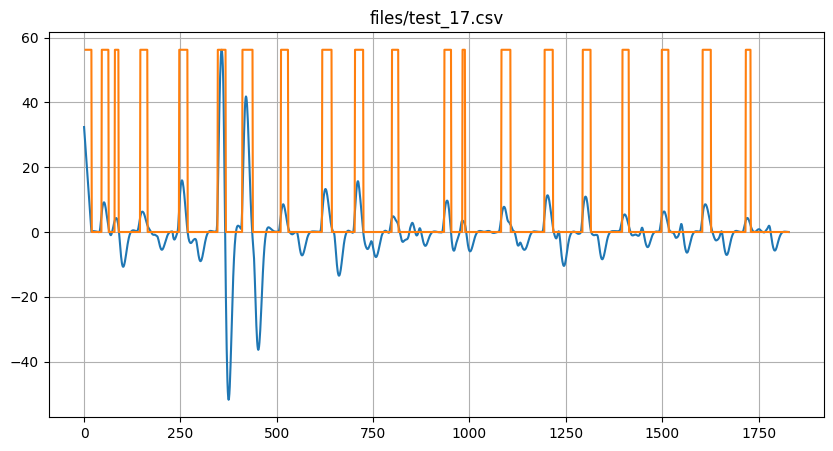

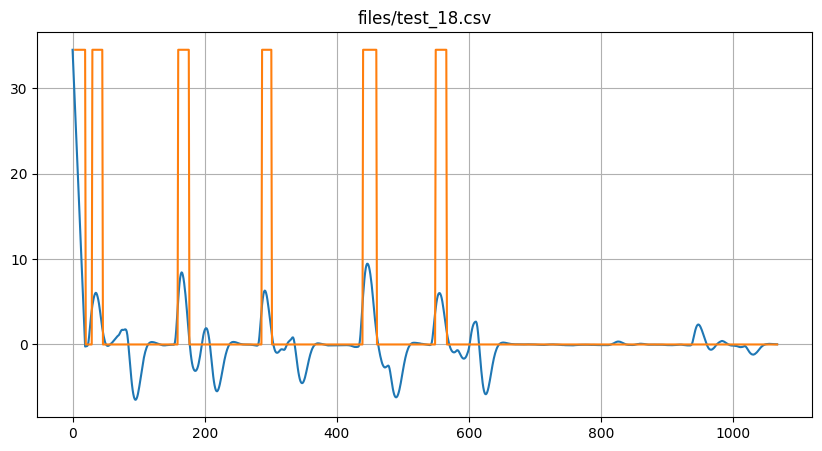

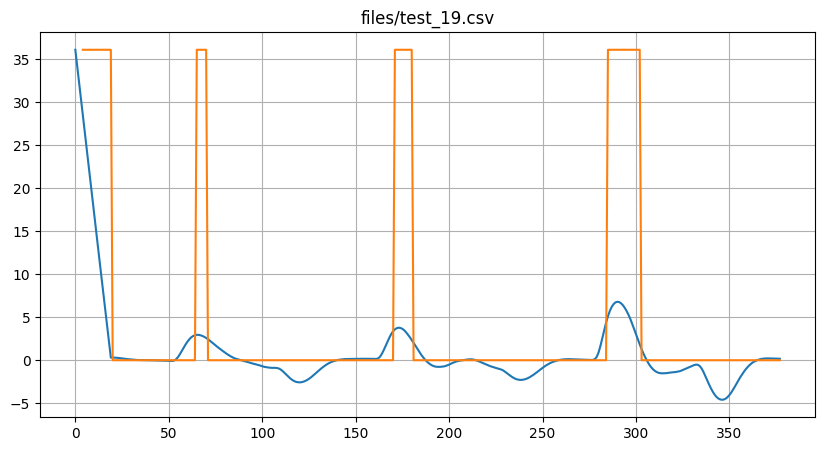

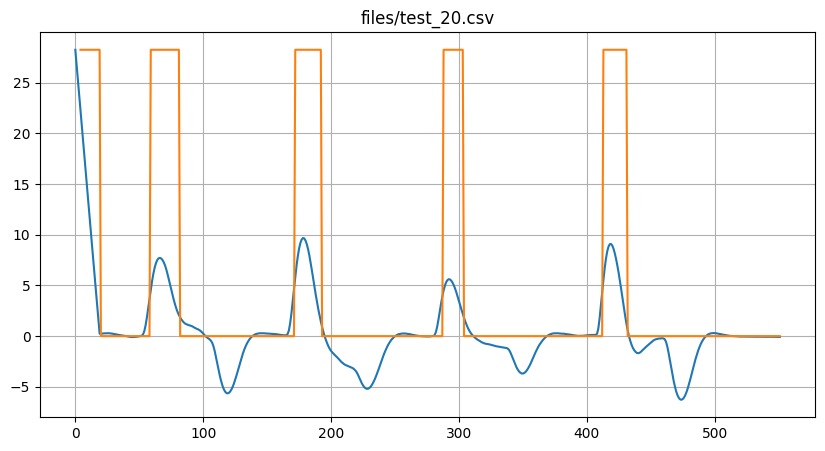

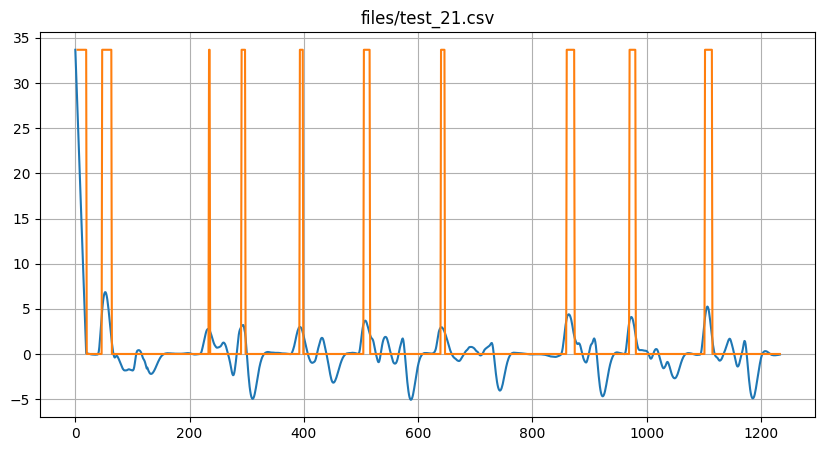

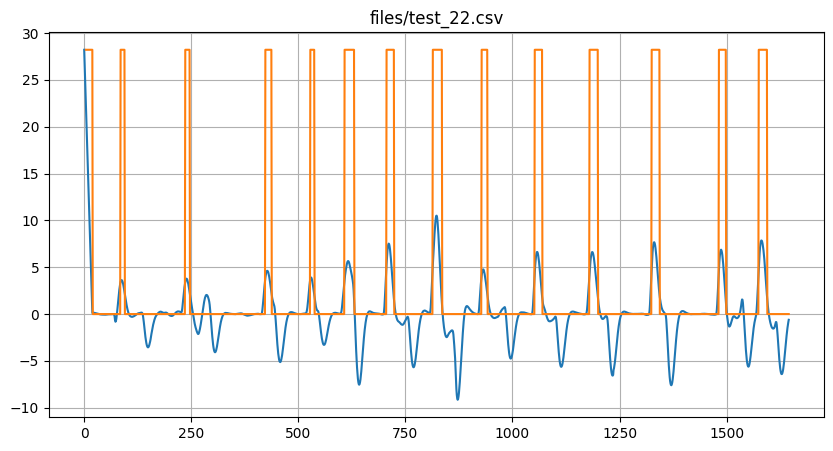

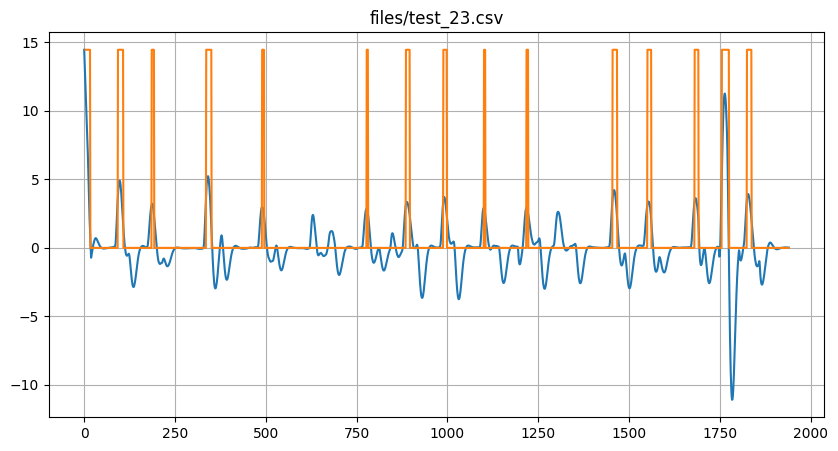

In [251]:
for file in files:
    df = pd.read_csv(file)

    smoother = Smoother(N_SMOOTHER)
    df['pressure'] = [value - smoother.update(value) for value in df.pressure.values]

    xData  = getStates(df, 'pressure', var='y', n=N_STATES)
    xData  = scaler.transform(xData)
    yModel = model.predict(xData)

    n_dropped = len(df) - len(yModel) 
    padding   = np.full(n_dropped, np.nan)
    df['model'] = np.concatenate([padding, yModel])

    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df.pressure)
    plt.plot(df.index, df.model*max(df.pressure))
    plt.title(file); plt.grid()
    plt.show()

In [252]:
print(f"const int STATES  = {N_STATES};")
print(f"const int CLASSES = {NUM_CLUSTERS};")

print()
print("float SCALER_MEAN[STATES] = {", ", ".join(map(str, scaler.mean_)), "};")
print("float SCALER_STD[STATES]  = {", ", ".join(map(str, scaler.scale_)), "};")

print()
print("float centroids[CLASSES][STATES] = {")

for center in model.cluster_centers_:
    print("\t{", ", ".join(map(str, center)), "},")
print("};")

const int STATES  = 5;
const int CLASSES = 2;

float SCALER_MEAN[STATES] = { 0.0018389100739659044, 0.0030949022176906776, 0.004429431722804109, 0.005842514536957158, 0.007334352102099594 };
float SCALER_STD[STATES]  = { 4.400394120593558, 4.40497188140637, 4.410134473103949, 4.415915658021759, 4.422348784563995 };

float centroids[CLASSES][STATES] = {
	{ -0.25719673289801204, -0.263008668861697, -0.26479906358047023, -0.2625961369098391, -0.2566773353614246 },
	{ 1.4624568747232007, 1.495504361795721, 1.5056847985199178, 1.4931586469717437, 1.4595035071219191 },
};
